/usr/local/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


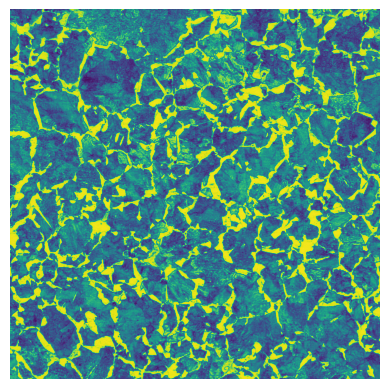

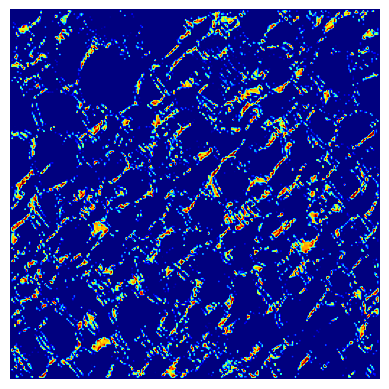

In [1]:
APP_PATH = '/root'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import japanize_matplotlib
from IPython.display import display
from torchinfo import summary
from torchviz import make_dot

import os
import sys
import cv2
from PIL import Image
import pandas as pd

from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image

import torch

# Grad-CAM
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

from torchsummary import summary

# モデル
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

n_output = 6
n_hidden = 128

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
    self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
    self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
    self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
    self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
    self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(131072, n_hidden) # 256 v2

    self.l2 = nn.Linear(n_hidden, n_output)
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.3)
    self.dropout3 = nn.Dropout(0.4)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)
    self.bn5 = nn.BatchNorm2d(128)
    self.bn6 = nn.BatchNorm2d(128)


    self.features = nn.Sequential(
        self.conv1,
        self.bn1,
        self.relu,
        self.conv2,
        self.bn2,
        self.relu,
        self.maxpool,
        self.dropout1,
        self.conv3,
        self.bn3,
        self.relu,
        self.conv4,
        self.bn4,
        self.relu,
        self.maxpool,
        self.dropout2,
        self.conv5,
        self.bn5,
        self.relu,
        self.conv6,
        self.bn6,
        self.relu,
        self.maxpool,
        self.dropout3
    )

    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2
    )

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

model = CNN(n_output, n_hidden)

# print('summary')
# summary(model, (3, 256, 256))

filename = 'AlexNet_model_max_weight.pth'
model.load_state_dict(torch.load(filename, map_location='cpu'))
model.eval()

# Grad-CAMを計算するためのモデルを作成
# print('model.features')
# summary(model.features)
# target_layer = model.features[-4]
target_layer = model.features[0]

gradcam = GradCAM(model, target_layer)

# 画像を読み込み、前処理を適用
datasets_npz_x1 = np.load(APP_PATH + '/dataset_npz/x.1_dataset/sc_x10_960_x1.npz')

images = datasets_npz_x1['x']
labels = datasets_npz_x1['y']

image = images[10]
dispaly_image = images[10]
label = labels[10]

image = Image.fromarray(image)
image = image.convert("RGB")
image = image.resize((256, 256))
image = np.asarray(image, np.float32)
image = image.astype(float) / 255.0
image = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)

target_class = label

# Grad-CAMの計算
heatmap = gradcam(image, target_class)

# ヒートマップを適切な形式に変換(正規化)
heatmap = heatmap[0].squeeze().cpu().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
heatmap = heatmap.astype(np.float32)
heatmap = torch.from_numpy(heatmap)

# 元の画像に可視化をオーバーレイ
visualization = visualize_cam(heatmap, image)

plt.imshow(dispaly_image)
plt.axis('off')
plt.show()

visualization_np = visualization[0][0].cpu().numpy()
plt.imshow(visualization_np, cmap='jet')
plt.axis('off')
plt.show()

# 可視化された画像を保存または表示

# cv2.imwrite('gradcam_visualization.jpg', visualization)
